In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import glob

In [2]:
total_images = []
total_label = []
for i in range(2):
    for j in range(2):
        for k in range(12):
            for l in range(2):
                string = str(i)+'_'+str(j)+'_'+str(k)+'_'+str(l)
                files = glob.glob("../q1/images/%s/*.jpg"%(string)) # image path
                for myFile in files:
                    image = cv2.imread (myFile)
                    total_images.append (image)
                    total_label.append((i,j,k,l))


In [3]:
total_images = np.array(total_images,dtype=float)
total_label = np.array(total_label,dtype=int)
n = total_images.shape[0]
print(total_images.shape)
print(total_label.shape)

(96000, 28, 28, 3)
(96000, 4)


In [4]:
total_images = total_images/255

In [5]:
total_labels = np.array(total_label,dtype=int)

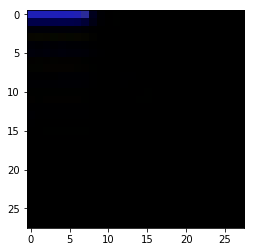

In [6]:
imgplot = plt.imshow(total_images[0])

plt.show()

In [7]:
total_images = np.reshape(total_images, (n, total_images.shape[1]*total_images.shape[2]*total_images.shape[3]))

In [8]:
total_labels = np.zeros(shape=(n, 96), dtype=int)
for i,t in enumerate(total_label):
    n2 = 48*t[0]+24*t[1]+t[2]*2+int(t[3])
    total_labels[i][n2] = 1

print(total_labels.shape)

(96000, 96)


In [9]:
learning_rate = 0.7
epochs = 30
batch_size = 100
# declare the training data placeholders
x = tf.placeholder(tf.float32, [None, 2352])
# now declare the output data placeholder 
y = tf.placeholder(tf.float32, [None, 96])

In [10]:
# now declare the weights connecting the input to the hidden layer
# Jai Bajrang Bali.
W1 = tf.Variable(tf.random_normal([2352, 121], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([121]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random_normal([121, 96], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([96]), name='b2')

In [11]:
# calculate the output of the hidden layer
hidden_out = tf.add(tf.matmul(x, W1), b1)
hidden_out = tf.nn.relu(hidden_out)

In [12]:
y_ = tf.nn.softmax(tf.add(tf.matmul(hidden_out, W2), b2))
confusion_matrix_tf = tf.confusion_matrix(tf.argmax(y, 1), tf.argmax(y_, 1))

In [13]:
y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)
                         + (1 - y) * tf.log(1 - y_clipped), axis=1))

In [14]:
# add an optimiser
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [15]:
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()
pred=tf.argmax(y_, 1)
# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [16]:
def shuffle(a,b):
    indices = np.arange(a.shape[0])
    np.random.shuffle(indices)
    a = a[indices]
    b = b[indices]
    return a,b

In [17]:
total_images, total_labels=shuffle(total_images, total_labels)

In [18]:
print(np.sum(total_images[0]))
print(np.max(total_images[0]))
print(np.argmax(total_labels[0]))

19.698039215686276
0.49019607843137253
53


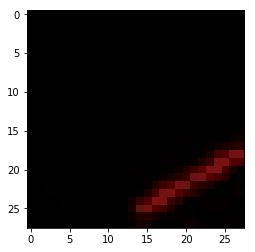

In [19]:
imgplot = plt.imshow(total_images[0].reshape(28,28,3))
plt.show()

In [20]:
train_images = total_images[:70000]
train_labels = total_labels[:70000]
test_images = total_images[70000:]
test_labels = total_labels[70000:]


In [21]:
# start the session
cm = tf.zeros(shape=[96,96], dtype=tf.int32)
with tf.Session() as sess:
    # initialise the variables
    sess.run(init_op)
    avg_cost = []
    accur_list=[]
    
    total_batch = int(len(train_labels) / batch_size)
    for epoch in range(epochs):
        avg_cost.append(0)
        accur_list.append(0)
        train_images, train_labels=shuffle(train_images, train_labels)
        for i in range(total_batch):
            batch_x=train_images[batch_size*i:batch_size*i+batch_size]
            batch_y=train_labels[batch_size*i:batch_size*i+batch_size]
            c = sess.run([optimiser, cross_entropy], 
                         feed_dict={x: batch_x, y: batch_y})
            avg_cost[epoch] += c[1] / total_batch
        accur_list[epoch]=sess.run(accuracy, feed_dict={x:test_images, y: test_labels})
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost[epoch]))
        
    predictions = pred.eval(feed_dict = {x:test_images})
    print(predictions)
    print(sess.run([accuracy], feed_dict={x:test_images, y: test_labels}))
    cm = confusion_matrix_tf.eval(feed_dict={x:test_images, y: test_labels})
    
    print(cm)
    
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F_scores = 2* (precision*recall)/(precision+recall)
    print(F_scores)

Epoch: 1 cost = 4.153
Epoch: 2 cost = 2.538
Epoch: 3 cost = 1.462
Epoch: 4 cost = 0.991
Epoch: 5 cost = 0.754
Epoch: 6 cost = 0.605
Epoch: 7 cost = 0.500
Epoch: 8 cost = 0.404
Epoch: 9 cost = 0.335
Epoch: 10 cost = 0.274
Epoch: 11 cost = 0.241
Epoch: 12 cost = 0.192
Epoch: 13 cost = 0.162
Epoch: 14 cost = 0.140
Epoch: 15 cost = 0.119
Epoch: 16 cost = 0.105
Epoch: 17 cost = 0.090
Epoch: 18 cost = 0.080
Epoch: 19 cost = 0.070
Epoch: 20 cost = 0.062
Epoch: 21 cost = 0.055
Epoch: 22 cost = 0.050
Epoch: 23 cost = 0.045
Epoch: 24 cost = 0.041
Epoch: 25 cost = 0.038
Epoch: 26 cost = 0.035
Epoch: 27 cost = 0.032
Epoch: 28 cost = 0.030
Epoch: 29 cost = 0.028
Epoch: 30 cost = 0.026
[44 82 83 ... 88 35 52]
[0.99688464]
[[251   0   3 ...   0   0   0]
 [  0 284   0 ...   0   0   0]
 [  4   0 262 ...   0   0   0]
 ...
 [  0   0   0 ... 281   0   0]
 [  0   0   0 ...   0 251   0]
 [  0   0   0 ...   0   0 281]]
[0.97098646 0.99474606 0.97217069 0.97902098 0.98540146 0.98194946
 1.         0.99805825 

In [22]:
def decoder(n):
    i=int(n/48)
    j=int((n%48)/24)
    k=int(((n%48)%24)/2)
    l=int(((n%48)%24)%2)
    return i,j,k,l

In [23]:
answer_class = list()
for i,t in enumerate(predictions):
    answer_class.append(decoder(t))

print (answer_class[1])

(1, 1, 5, 0)


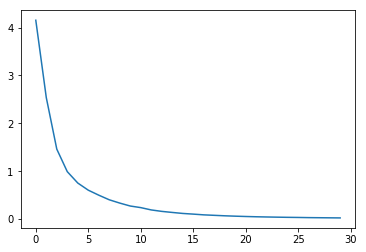

In [24]:
plt.plot(range(epochs), avg_cost)
plt.show()

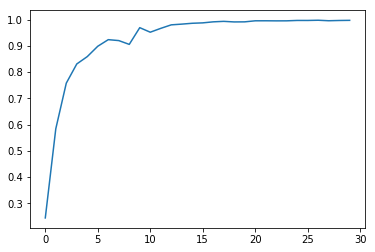

In [25]:
plt.plot(range(epochs), accur_list)
plt.show()

In [27]:
np.save('confusion.npy', cm)
np.save('fscore.npy', F_scores)